# Análisis de sentimientos de sitios web

José Antonio Garcia Antona

usaremos los pipelines de transfromer:

<https://huggingface.co/docs/transformers/main_classes/pipelines>

In [145]:
# Instalación de librerías necesarias
# Si aún no tienes las librerías instaladas
#!pip install requests beautifulsoup4 transformers matplotlib seaborn
from transformers import pipeline

# Importación de librerías
from bs4 import BeautifulSoup
import requests
from transformers import pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [146]:
# Crea una instancia del clasificador de texto
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
classifier = pipeline("sentiment-analysis", model=model_name)
# 1 estrella negativo
# 5 estrellas positivo

In [147]:
# Función para obtener titulares de un periódico
def get_headlines(url):
    """
    Obtiene titulares de la página principal del periódico extraído de la URL.

    Args:
        url (str): URL de la página principal del periódico.

    Returns:
        list: Lista de titulares extraídos.
    """

    # Diccionario con selectores CSS específicos para cada periódico
    selectors = {
        "elpais": ".c_t a",  # Selector actualizado para El País
        "abc": "h2 a",
        "bbc": "h2"
    }

    # Intentar extraer el nombre base del dominio
    try:
        newspaper = re.search(r"https?://(?:www\.)?([a-z]+)", url).group(1)
    except AttributeError:
        raise ValueError("No se pudo extraer el nombre del periódico de la URL.")

    if newspaper not in selectors:
        raise ValueError(f"Periódico '{newspaper}' no soportado. Usa uno de {list(selectors.keys())}.")

    # Encabezados para simular un navegador
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36'
    }

    # Realizar la solicitud HTTP
    try:
        response = requests.get(url, headers=headers)  # Añadimos headers aquí
        response.raise_for_status()  # Asegurarse de que la respuesta sea exitosa
    except requests.exceptions.RequestException as e:
        raise RuntimeError(f"Error al acceder a la URL: {e}")

    # Analizar el HTML
    soup = BeautifulSoup(response.content, 'html.parser')
    selector = selectors[newspaper]
    headlines = [h.text.strip() for h in soup.select(selector)]

    if not headlines:
        raise RuntimeError("No se encontraron titulares. Verifica el selector CSS.")

    return headlines[:100]  # Limitar a los primeros 10 titulares

In [148]:
# Análisis de sentimientos
def analyze_sentiments(headlines):
    results = []
    for headline in headlines:
        sentiment = classifier(headline)[0]
        results.append({
            'headline': headline,
            'label': sentiment['label'],
            'score': sentiment['score']
        })
    return results

In [149]:
# Visualización de resultados
def visualize_results(results):
    # Conteo de etiquetas
    labels = [r['label'] for r in results]
    sns.countplot(x=labels, palette="viridis")
    plt.title("Distribución de Sentimientos")
    plt.xlabel("Sentimientos")
    plt.ylabel("Cantidad")
    plt.show()

    # Mostrar titulares más positivos y negativos
    sorted_results = sorted(results, key=lambda x: x['score'], reverse=True)
    print("\n*** Titular más positivo ***")
    print(f"{sorted_results[0]['headline']} (Score: {sorted_results[0]['score']:.2f})")

    print("\n*** Titular más negativo ***")
    negative_results = [r for r in sorted_results if r['label'] == 'NEGATIVE']
    if negative_results:
        print(f"{negative_results[0]['headline']} (Score: {negative_results[0]['score']:.2f})")
    else:
        print("No hay titulares negativos en este análisis.")



In [150]:
# Flujo principal
#if __name__ == "__main__":
#    # URL del periódico (puedes cambiarla según tu preferencia)
#    url = "https://www.bbc.com/news"  # Cambiar al periódico deseado
#
    # print("Extrayendo titulares...")
    # headlines = get_headlines(url)
    # print(f"Titulares obtenidos:\n{headlines}")

    # print("\nAnalizando sentimientos...")
    # results = analyze_sentiments(headlines)
    # print("\nResultados:")
    # for result in results:
    #     print(f"{result['headline']} -> {result['label']} (Score: {result['score']:.2f})")

    # print("\nVisualizando resultados...")
    # visualize_results(results)

In [151]:
# El pais
url = "https://elpais.com/"
headlines = get_headlines(url)
print("Titulares de El País:")
print(headlines)

Titulares de El País:
['Las empresas de Estados Unidos amplían ‘stocks’ ante los aranceles previstos para el primer día de Trump', 'Universidades y escuelas se preparan para proteger a sus alumnos indocumentados de Donald Trump', 'El agua en Texas, el combustible de un milagro económico en riesgo de evaporarse', 'Una sentencia obliga a México a crear un registro de detenciones de migrantes', 'La ‘bananalidad’ del mal', 'Asia, a la espera de Trump 2.0', 'Las voces de los últimos exiliados españoles en México', 'En los entresijos de la FIL con María Dueñas: “He llegado a no ir a ferias porque había una preminencia de señoros”', 'Los clubs de lectura, la nueva pepita de oro del sector editorial', 'Begoña Rodrigo, cocinera: “Tenemos que hacer sentir al cliente que el precio que paga por un vegetal es tan importante como el de un caviar”', 'Begoña, ¿qué hay de comer?', 'El presidente Biden indulta a su hijo Hunter de los casos de posesión ilegal de un arma y fraude fiscal', 'El éxodo silenc

In [152]:
results = classifier(headlines)

# Imprimir los resultados
for headline, result in zip(headlines, results):
    print(f"Texto: {headline}\nSentimiento: {result['label']} (Puntaje: {result['score']:.4f})\n")


Texto: Las empresas de Estados Unidos amplían ‘stocks’ ante los aranceles previstos para el primer día de Trump
Sentimiento: 5 stars (Puntaje: 0.3792)

Texto: Universidades y escuelas se preparan para proteger a sus alumnos indocumentados de Donald Trump
Sentimiento: 4 stars (Puntaje: 0.3990)

Texto: El agua en Texas, el combustible de un milagro económico en riesgo de evaporarse
Sentimiento: 5 stars (Puntaje: 0.3681)

Texto: Una sentencia obliga a México a crear un registro de detenciones de migrantes
Sentimiento: 1 star (Puntaje: 0.4516)

Texto: La ‘bananalidad’ del mal
Sentimiento: 1 star (Puntaje: 0.3740)

Texto: Asia, a la espera de Trump 2.0
Sentimiento: 4 stars (Puntaje: 0.2651)

Texto: Las voces de los últimos exiliados españoles en México
Sentimiento: 5 stars (Puntaje: 0.3733)

Texto: En los entresijos de la FIL con María Dueñas: “He llegado a no ir a ferias porque había una preminencia de señoros”
Sentimiento: 1 star (Puntaje: 0.2565)

Texto: Los clubs de lectura, la nueva pe

Texto | Sentimiento (Estrellas) 
Las empresas de Estados Unidos amplían ‘stocks’ ante los aranceles previstos para el primer día de Trump | 5 estrellas
Universidades y escuelas se preparan para proteger a sus alumnos indocumentados de Donald Trump | 4 estrellas
El agua en Texas, el combustible de un milagro económico en riesgo de evaporarse | 5 estrellas
Una sentencia obliga a México a crear un registro de detenciones de migrantes | 1 estrellas
La ‘bananalidad’ del mal | 1 estrellas
Asia, a la espera de Trump 2.0 | 4 estrellas
Las voces de los últimos exiliados españoles en México | 5 estrellas
En los entresijos de la FIL con María Dueñas: “He llegado a no ir a ferias porque había una preminencia de señoros” | 1 estrellas
Los clubs de lectura, la nueva pepita de oro del sector editorial | 5 estrellas
Begoña Rodrigo, cocinera: “Tenemos que hacer sentir al cliente que el precio que paga por un vegetal es tan importante como el de un caviar” | 4 estrellas
Begoña, ¿qué hay de comer? | 5 es

<ipython-input-153-0c1676934377>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=stars, palette="viridis")


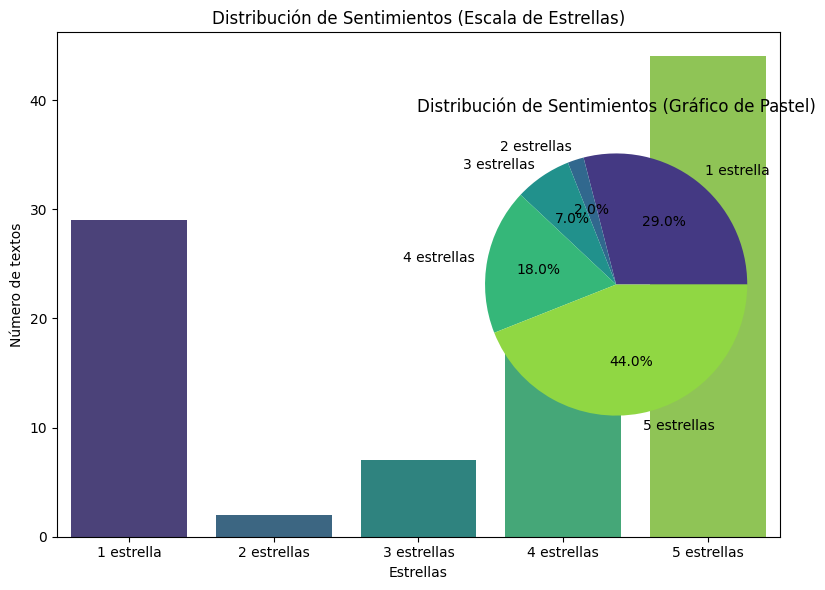

In [153]:
# Extraer las etiquetas de estrellas (1-5)
labels = [result['label'] for result in results]
# Convertir las etiquetas de 'X star' a enteros (1-5)
stars = [int(label.split()[0]) for label in labels]

# Mostrar resultados en formato de estrellas
print("Texto | Sentimiento (Estrellas) ")
for headline, star in zip(headlines, stars):
    print(f"{headline} | {star} estrellas")

# Crear un gráfico de barras para mostrar la distribución de las estrellas
plt.figure(figsize=(8, 6))
sns.countplot(x=stars, palette="viridis")

# Agregar título y etiquetas
plt.title("Distribución de Sentimientos (Escala de Estrellas)")
plt.xlabel("Estrellas")
plt.ylabel("Número de textos")
plt.xticks([0, 1, 2, 3, 4], ["1 estrella", "2 estrellas", "3 estrellas", "4 estrellas", "5 estrellas"])

# Gráfico de pastel
plt.subplot(1, 2, 2)
labels_pie = ["1 estrella", "2 estrellas", "3 estrellas", "4 estrellas", "5 estrellas"]
sizes = [stars.count(i + 1) for i in range(5)]
plt.pie(sizes, labels=labels_pie, autopct='%1.1f%%', colors=sns.color_palette("viridis", 5))
plt.title("Distribución de Sentimientos (Gráfico de Pastel)")

# Mostrar ambos gráficos
plt.tight_layout()
plt.show()

In [154]:
# ABC
url = "https://www.abc.es/"
headlines = get_headlines(url)
print("Titulares de ABC:")
print(headlines)

Titulares de ABC:
['Sánchez apuesta por confrontar para recuperar el poder territorial', 'Empieza la lucha regional en el PSOE: «Donde no hay poder, habrá batalla»', 'La nueva ejecutiva devalúa las enmiendas sobre los deportistas trans', 'El barco del capitán Achab', 'Un congreso a la búlgara', 'Cacería humana en sede judicial', 'Agrupémonos todos en la lucha final', 'Biden aprovecha sus últimas semanas en la Casa Blanca para indultar a su hijo', 'Los sectores del campo y de empleadas del hogar destruyen 147.000 empleos desde que comenzó a subir el SMI', 'El coronel que condecoró a Aldama y otros siete guardias civiles testifican en el caso Koldo', 'Glovo anuncia que contratará a todos sus repartidores un día antes de que su CEO vaya a juicio', 'Rodríguez Uribes: «Voy a intentar influir en el candidato a la RFEF por la vía de la persuasión»', 'El nuevo presidente de RTVE se estrena con la vista puesta en la BBC', 'Al menos dos muertos tras el accidente de un autobús español en los Piri

In [155]:
results = classifier(headlines)

# Imprimir los resultados
for headline, result in zip(headlines, results):
    print(f"Texto: {headline}\nSentimiento: {result['label']} (Puntaje: {result['score']:.4f})\n")


Texto: Sánchez apuesta por confrontar para recuperar el poder territorial
Sentimiento: 4 stars (Puntaje: 0.3810)

Texto: Empieza la lucha regional en el PSOE: «Donde no hay poder, habrá batalla»
Sentimiento: 4 stars (Puntaje: 0.2556)

Texto: La nueva ejecutiva devalúa las enmiendas sobre los deportistas trans
Sentimiento: 2 stars (Puntaje: 0.2638)

Texto: El barco del capitán Achab
Sentimiento: 5 stars (Puntaje: 0.3406)

Texto: Un congreso a la búlgara
Sentimiento: 5 stars (Puntaje: 0.4037)

Texto: Cacería humana en sede judicial
Sentimiento: 4 stars (Puntaje: 0.2407)

Texto: Agrupémonos todos en la lucha final
Sentimiento: 5 stars (Puntaje: 0.5053)

Texto: Biden aprovecha sus últimas semanas en la Casa Blanca para indultar a su hijo
Sentimiento: 4 stars (Puntaje: 0.4025)

Texto: Los sectores del campo y de empleadas del hogar destruyen 147.000 empleos desde que comenzó a subir el SMI
Sentimiento: 1 star (Puntaje: 0.6908)

Texto: El coronel que condecoró a Aldama y otros siete guardias

Texto | Sentimiento (Estrellas) 
Sánchez apuesta por confrontar para recuperar el poder territorial | 4 estrellas
Empieza la lucha regional en el PSOE: «Donde no hay poder, habrá batalla» | 4 estrellas
La nueva ejecutiva devalúa las enmiendas sobre los deportistas trans | 2 estrellas
El barco del capitán Achab | 5 estrellas
Un congreso a la búlgara | 5 estrellas
Cacería humana en sede judicial | 4 estrellas
Agrupémonos todos en la lucha final | 5 estrellas
Biden aprovecha sus últimas semanas en la Casa Blanca para indultar a su hijo | 4 estrellas
Los sectores del campo y de empleadas del hogar destruyen 147.000 empleos desde que comenzó a subir el SMI | 1 estrellas
El coronel que condecoró a Aldama y otros siete guardias civiles testifican en el caso Koldo | 5 estrellas
Glovo anuncia que contratará a todos sus repartidores un día antes de que su CEO vaya a juicio | 1 estrellas
Rodríguez Uribes: «Voy a intentar influir en el candidato a la RFEF por la vía de la persuasión» | 1 estrellas

<ipython-input-156-0c1676934377>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=stars, palette="viridis")


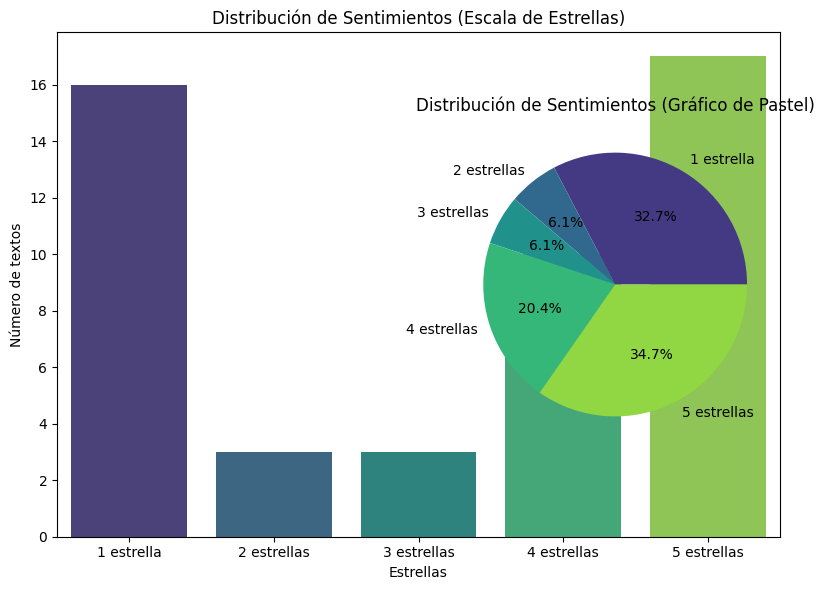

In [156]:
# Extraer las etiquetas de estrellas (1-5)
labels = [result['label'] for result in results]
# Convertir las etiquetas de 'X star' a enteros (1-5)
stars = [int(label.split()[0]) for label in labels]

# Mostrar resultados en formato de estrellas
print("Texto | Sentimiento (Estrellas) ")
for headline, star in zip(headlines, stars):
    print(f"{headline} | {star} estrellas")

# Crear un gráfico de barras para mostrar la distribución de las estrellas
plt.figure(figsize=(8, 6))
sns.countplot(x=stars, palette="viridis")

# Agregar título y etiquetas
plt.title("Distribución de Sentimientos (Escala de Estrellas)")
plt.xlabel("Estrellas")
plt.ylabel("Número de textos")
plt.xticks([0, 1, 2, 3, 4], ["1 estrella", "2 estrellas", "3 estrellas", "4 estrellas", "5 estrellas"])

# Gráfico de pastel
plt.subplot(1, 2, 2)
labels_pie = ["1 estrella", "2 estrellas", "3 estrellas", "4 estrellas", "5 estrellas"]
sizes = [stars.count(i + 1) for i in range(5)]
plt.pie(sizes, labels=labels_pie, autopct='%1.1f%%', colors=sns.color_palette("viridis", 5))
plt.title("Distribución de Sentimientos (Gráfico de Pastel)")

# Mostrar ambos gráficos
plt.tight_layout()
plt.show()

In [157]:
# BBC
url = "https://www.bbc.com"
headlines = get_headlines(url)
print("Titulares de BBC:")
print(headlines)

Titulares de BBC:
["Hunter Biden's pardon shows rulebook being rewritten", "Bowen: Syria's rebel offensive is astonishing - but don't write off Assad", "Hunter Biden's pardon shows rulebook being rewritten", "Bowen: Syria's rebel offensive is astonishing - but don't write off Assad", "Joe Biden issues 'full and unconditional' pardon for son Hunter", '‘Italian’ purees in UK supermarkets likely to contain Chinese forced-labour tomatoes', "Georgia's PM hits back as protests and resignations intensify", 'BBC hears of horror and hunger in Sudan massacre town', 'She fled Israeli bombing four times. It still found her', 'Only from the BBC', 'The forgotten street found behind a hidden library door', 'The overlooked benefits of real Christmas trees', 'More news', 'Three dead and dozens sick after eating sea turtle stew', 'Stellantis boss abruptly quits in boardroom clash', 'Norway suspends controversial deep-sea mining plan', 'Dozens killed in crush at Guinea football match - reports', 'Losing 

In [158]:
results = classifier(headlines)

# Imprimir los resultados
for headline, result in zip(headlines, results):
    print(f"Texto: {headline}\nSentimiento: {result['label']} (Puntaje: {result['score']:.4f})\n")


Texto: Hunter Biden's pardon shows rulebook being rewritten
Sentimiento: 1 star (Puntaje: 0.4472)

Texto: Bowen: Syria's rebel offensive is astonishing - but don't write off Assad
Sentimiento: 3 stars (Puntaje: 0.3725)

Texto: Hunter Biden's pardon shows rulebook being rewritten
Sentimiento: 1 star (Puntaje: 0.4472)

Texto: Bowen: Syria's rebel offensive is astonishing - but don't write off Assad
Sentimiento: 3 stars (Puntaje: 0.3725)

Texto: Joe Biden issues 'full and unconditional' pardon for son Hunter
Sentimiento: 1 star (Puntaje: 0.6123)

Texto: ‘Italian’ purees in UK supermarkets likely to contain Chinese forced-labour tomatoes
Sentimiento: 1 star (Puntaje: 0.4051)

Texto: Georgia's PM hits back as protests and resignations intensify
Sentimiento: 4 stars (Puntaje: 0.2530)

Texto: BBC hears of horror and hunger in Sudan massacre town
Sentimiento: 1 star (Puntaje: 0.3313)

Texto: She fled Israeli bombing four times. It still found her
Sentimiento: 3 stars (Puntaje: 0.2338)

Texto: 

Texto | Sentimiento (Estrellas) 
Hunter Biden's pardon shows rulebook being rewritten | 1 estrellas
Bowen: Syria's rebel offensive is astonishing - but don't write off Assad | 3 estrellas
Hunter Biden's pardon shows rulebook being rewritten | 1 estrellas
Bowen: Syria's rebel offensive is astonishing - but don't write off Assad | 3 estrellas
Joe Biden issues 'full and unconditional' pardon for son Hunter | 1 estrellas
‘Italian’ purees in UK supermarkets likely to contain Chinese forced-labour tomatoes | 1 estrellas
Georgia's PM hits back as protests and resignations intensify | 4 estrellas
BBC hears of horror and hunger in Sudan massacre town | 1 estrellas
She fled Israeli bombing four times. It still found her | 3 estrellas
Only from the BBC | 1 estrellas
The forgotten street found behind a hidden library door | 5 estrellas
The overlooked benefits of real Christmas trees | 5 estrellas
More news | 3 estrellas
Three dead and dozens sick after eating sea turtle stew | 1 estrellas
Stellant

<ipython-input-159-0c1676934377>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=stars, palette="viridis")


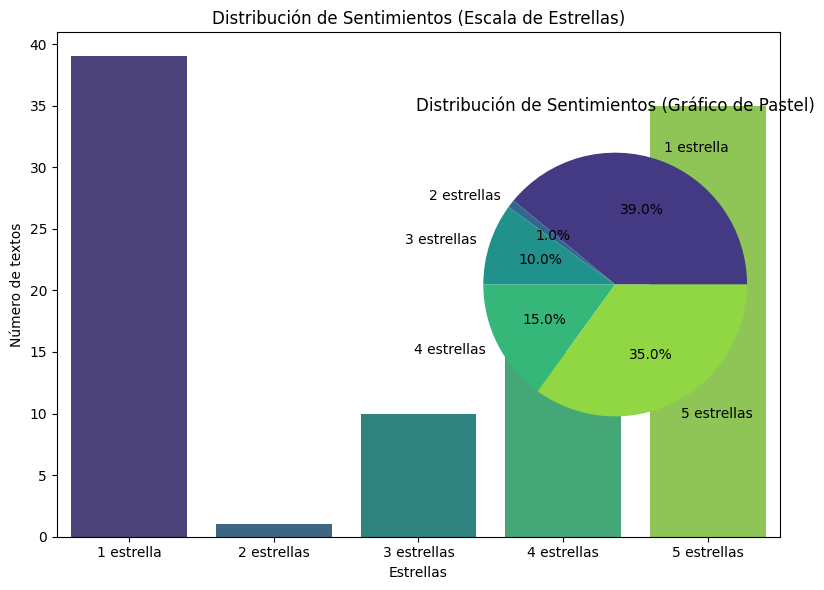

In [159]:
# Extraer las etiquetas de estrellas (1-5)
labels = [result['label'] for result in results]
# Convertir las etiquetas de 'X star' a enteros (1-5)
stars = [int(label.split()[0]) for label in labels]

# Mostrar resultados en formato de estrellas
print("Texto | Sentimiento (Estrellas) ")
for headline, star in zip(headlines, stars):
    print(f"{headline} | {star} estrellas")

# Crear un gráfico de barras para mostrar la distribución de las estrellas
plt.figure(figsize=(8, 6))
sns.countplot(x=stars, palette="viridis")

# Agregar título y etiquetas
plt.title("Distribución de Sentimientos (Escala de Estrellas)")
plt.xlabel("Estrellas")
plt.ylabel("Número de textos")
plt.xticks([0, 1, 2, 3, 4], ["1 estrella", "2 estrellas", "3 estrellas", "4 estrellas", "5 estrellas"])

# Gráfico de pastel
plt.subplot(1, 2, 2)
labels_pie = ["1 estrella", "2 estrellas", "3 estrellas", "4 estrellas", "5 estrellas"]
sizes = [stars.count(i + 1) for i in range(5)]
plt.pie(sizes, labels=labels_pie, autopct='%1.1f%%', colors=sns.color_palette("viridis", 5))
plt.title("Distribución de Sentimientos (Gráfico de Pastel)")

# Mostrar ambos gráficos
plt.tight_layout()
plt.show()